In [1]:
## PyTorch
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
# import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export

matplotlib.rcParams['lines.linewidth'] = 2.0

sns.reset_orig()

/tmp/ipykernel_4859/3867451908.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [2]:
import random
import numpy as np
import os
from icecream import ic

# from lightning.pytorch.loggers import WandbLogger
# from lightning.pytorch import Trainer

# wandb_logger = WandbLogger(log_model="all")
# trainer = Trainer(logger=wandb_logger)

In [3]:
from PIL import Image
from types import SimpleNamespace

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline




In [4]:
ic.disable()

In [5]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/t5"

# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
os.makedirs(DATASET_PATH, exist_ok=True)



In [7]:
# import urllib.request
# from urllib.error import HTTPError
# # Github URL where saved models are stored for this tutorial
# base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial5/"
# # Files to download
# pretrained_files = ["GoogleNet.ckpt", "ResNet.ckpt", "ResNetPreAct.ckpt", "DenseNet.ckpt",
#                     "tensorboards/GoogleNet/events.out.tfevents.googlenet",
#                     "tensorboards/ResNet/events.out.tfevents.resnet",
#                     "tensorboards/ResNetPreAct/events.out.tfevents.resnetpreact",
#                     "tensorboards/DenseNet/events.out.tfevents.densenet"]
# # Create checkpoint path if it doesn't exist yet
# os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# # For each file, check whether it already exists. If not, try downloading it.
# for file_name in pretrained_files:
#     file_path = os.path.join(CHECKPOINT_PATH, file_name)
#     if "/" in file_name:
#         os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
#     if not os.path.isfile(file_path):
#         file_url = base_url + file_name
#         print(f"Downloading {file_url}...")
#         # try:
#         urllib.request.urlretrieve(file_url, file_path)

In [8]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, download=True)
train_dataset.data.shape

Files already downloaded and verified


(50000, 32, 32, 3)

In [9]:
DATA_MEANS = (train_dataset.data/255.0).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data/255.0).std(axis=(0,1,2))
DATA_MEANS, DATA_STD

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [10]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [11]:
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,2,3]))
print("Batch std", imgs.std(dim=[0,2,3]))

Batch mean tensor([0.0231, 0.0006, 0.0005])
Batch std tensor([0.9865, 0.9849, 0.9868])


In [12]:
img, lab = next(iter(train_loader))
img.shape, lab.shape

(torch.Size([128, 3, 32, 32]), torch.Size([128]))

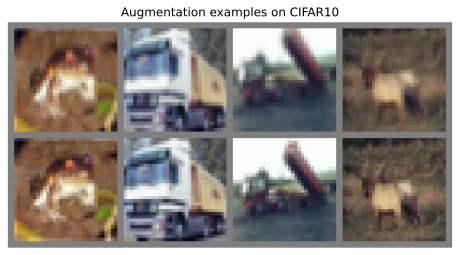

In [13]:
NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

PYTORCH LIGHTING

In [14]:
import pytorch_lightning as pl
pl.seed_everything(42)

/home/ubuntu/miniconda3/envs/lrenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Seed set to 42


42

In [15]:
model_dict = {}
def create_model(model_name, model_hparams):
    ic(model_hparams)
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f'Unknown model name \"{model_name}\". Available models are {str(model_dict.keys())}'

In [16]:
# from typing import Any

# from icecream import ic
class CIFARModule(pl.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        super().__init__()
        self.save_hyperparameters()
        self.model = create_model(model_name, model_hparams)
        self.loss_module = nn.CrossEntropyLoss()
        self.example_input_array = torch.zeros((1, 3, 32, 32), dtype=torch.float32)
    def forward(self, imgs):
        return self.model(imgs) 
    def configure_optimizers(self):
        if self.hparams.optimizer_name == 'Adam':
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == 'SGD':
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f'Unknown optimizer: \ {self.hparams.optimizer_name}'
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        # ic(imgs.shape)
        preds = self.model(imgs)
        # ic(preds.shape)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1)==labels).float().mean()

        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs are per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

In [17]:
# Callbacks
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [18]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

In [19]:
def train_model(model_name, save_name=None, **kwargs):
    ic(kwargs)
    if save_name is None:
        save_name = model_name
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),
                         accelerator="gpu" if str(device).startswith('cuda') else 'cpu',
                         devices=1,
                         max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor('epoch')],
                                    enable_progress_bar=True)
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None
    # trainer.logger.
    file_name_path = os.path.join(CHECKPOINT_PATH, save_name +'.ckpt')
    ic(file_name_path)
    if os.path.isfile(file_name_path):
        print(f'skipping training for model {file_name_path}')
        model = CIFARModule.load_from_checkpoint(file_name_path)    
    else:
        pl.seed_everything(42)
        model = CIFARModule(model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = CIFARModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    val_result = trainer.test(model, val_loader, verbose=False)
    ic(val_result)
    test_result = trainer.test(model, test_loader, verbose=False)
    ic(test_result)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    return model, result

In [20]:
class InceptionBlock(nn.Module):
    def __init__(self, c_in, c_red:dict, c_out:dict, act_fn):
        super().__init__()
        # 1X1 convolution branch 
        # all convolutions are 2d and NOT 1d 
        self.conv_1x1 = nn.Sequential(nn.Conv2d(c_in, c_out['1x1'], kernel_size=1), 
                                      nn.BatchNorm2d(c_out['1x1']),
                                      act_fn())
        self.conv_3x3 = nn.Sequential(nn.Conv2d(c_in, c_red['3x3'], kernel_size=1), 
                                      nn.BatchNorm2d(c_red['3x3']),
                                      act_fn(),
                                      nn.Conv2d(c_red['3x3'], c_out['3x3'], kernel_size=3, padding=                                                  1),
                                      nn.BatchNorm2d(c_out['3x3']),
                                      act_fn())
        
        self.conv_5x5 = nn.Sequential(nn.Conv2d(c_in, c_red['5x5'], kernel_size=1), 
                                      nn.BatchNorm2d(c_red['5x5']),
                                      act_fn(),
                                      nn.Conv2d(c_red['5x5'], c_out['5x5'], kernel_size=5, padding=2),
                                      nn.BatchNorm2d(c_out['5x5']),
                                      act_fn())
        self.max_pool = nn.Sequential(nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
                                      nn.Conv2d(c_in, c_out['max'], kernel_size=1),
                                      nn.BatchNorm2d(c_out['max']),
                                      act_fn())
    def forward(self, x):
        x_1x1 = self.conv_1x1(x)    
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max_pool = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max_pool], dim=1)
        return x_out

In [21]:
class GoogleNet(nn.Module):
    def __init__(self, num_classes=10, act_fn_name='relu', **kwargs) -> None:
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()
    def _create_network(self):
        self.input_net =  nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         self.hparams.act_fn()
                                         )  
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )
    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias, 0)
    def forward(self,x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [22]:
model_dict["GoogleNet"] = GoogleNet

In [23]:
googlenet_model, googlenet_results = train_model(model_name="GoogleNet",
                                                 model_hparams={"num_classes": 10,
                                                                "act_fn_name": "relu"},
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


skipping training for model ../saved_models/t5/GoogleNet.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 43.21it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:01<00:00, 51.20it/s]


In [24]:
print("GoogleNet Results", googlenet_results)

GoogleNet Results {'test': 0.8971999883651733, 'val': 0.8996000289916992}


In [25]:
ic.enable()

In [31]:
class ResnetBlock(nn.Module):
    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        super().__init__()
        if not subsample:
            c_out = c_in
        
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=1
                      if not subsample else 2, bias=False),
            nn.BatchNorm2d(c_out),
            act_fn(),
            nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out)
        )
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()
         
    def forward(self, x):
        z = self.net(x)
        ic(z.shape, x.shape)
        if self.downsample is not None:
            x = self.downsample(x)
        ic(z.shape, x.shape)
        out = z+x
        out = self.act_fn(out) 
        ic(out.shape)
        return out

In [33]:
res = ResnetBlock(3,nn.ReLU,subsample=False, c_out=8)
inp = torch.ones(size=(128, 3, 28, 28))
with torch.no_grad():
    out = res(inp)


ic| z.shape: torch.Size([128, 3, 28, 28])
    x.shape: torch.Size([128, 3, 28, 28])
ic| z.shape: torch.Size([128, 3, 28, 28])
    x.shape: torch.Size([128, 3, 28, 28])
ic| out.shape: torch.Size([128, 3, 28, 28])
ic| out.shape: torch.Size([128, 3, 28, 28])


In [52]:
class PreActResnetBlock(nn.Module):
    def __init__(self, c_in, act_fn=nn.ReLU, subsample=False, c_out=-1):
        super().__init__()
        if not subsample:
            c_out=c_in
        self.net = nn.Sequential(nn.BatchNorm2d(c_in),
                                 act_fn(),
                                 nn.Conv2d(c_in, c_out, kernel_size=3, stride=2 if subsample else 1,
                                           padding=1, bias=False),
                                 nn.BatchNorm2d(c_out),
                                 act_fn(),
                                 nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False)
        )
        self.downsample = nn.Sequential(nn.BatchNorm2d(c_in),
                                        act_fn(),
                                        nn.Conv2d(c_in, c_out, kernel_size=1, stride=2, bias=False)
                                        ) if subsample else None
    def forward(self, x):
        z = self.net(x)
        if self.downsample is not None:
            x = self.downsample(x)
        ic(x.shape, z.shape)
        out = z+x
        ic(x.shape, z.shape, out.shape)
        return out

In [57]:
pares = PreActResnetBlock(3, subsample=True, c_out=8)
inp = torch.ones(size=(128, 3, 28, 28))
with torch.no_grad():
    out = pares(inp)

ic| x.shape: torch.Size([128, 8, 14, 14])
    z.shape: torch.Size([128, 8, 14, 14])
ic| x.shape: torch.Size([128, 8, 14, 14])
    z.shape: torch.Size([128, 8, 14, 14])
    out.shape: torch.Size([128, 8, 14, 14])


In [58]:
resnet_block_by_name = {'ResnetBlock':ResnetBlock,
                        'PreActResnetBlock':PreActResnetBlock}

In [ ]:
class ResNet